# Implementação do paper **Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks**

Esse paper propos uma extensão as arquiteturas GAN, incluindo camadas convolucionais, o que possibilitou com que o modelo aprendesse representações hierarquicas das imagens de entrada.

Além de estabelecer boas praticas para as redes de geração e descriminação, esse paper demonstrou que a rede DCGAN pode aprender representações de altissima qualidade, resultado em boas imagens artificiais de digitos, faces e cenas.

*Paper disponivel em: https://arxiv.org/abs/1511.06434

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from PIL import Image
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Download do Dataset

Para essa implementação, utilizaremos o dataset Stanford Cars. Além disso aplicaremos uma transformação simples, normalizando-o com 0.5 na media e variancia.

A depender de seu hardware, será necessario diminuir o batch_size para poupar recursos no treinamento em GPU/CPU

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = datasets.StanfordCars('./data', download=True, split='train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=False, num_workers=7)


## 2. Criação dos Modelos

Conforme descrito no paper de Alec Radford, devemos criar dois modelos: discriminador e gerador.

* Gerador: O gerador é uma rede que recebe um vetor de tamanho N e realiza uma serie de deconvoluções (ConvTranspose2d no Pytorch) com normalização do batch (BatchNorm2d no PyTorch) e ReLU. Ao final, é aplicado a ativação como tangente hiperbolica. Na figura abaixo temos a representação da rede, retirada do paper original.

![image](https://pytorch.org/tutorials/_images/dcgan_generator.png)

* Discriminador: Rede com camadas convolucionais, que, receberá uma imagem com as seguintes dimensões (N, 3, 32, 32) e terá como output um escalar entre 0 e 1. Essa rede será treinada para tentar diferenciar o que é uma image "fake" de uma imagem "real".


In [6]:
class Descriminator(nn.Module):
    
    def __init__(self, channels, features):
        super(Descriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(channels, features, 4, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features, features*2, 4, 2, 1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*2, features*4, 4, 2, 1),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*4, features*8, 4, 2, 1),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(features*8, 1, 4, 2, 0),
            nn.Sigmoid()
        )

    
    def forward(self, img):
        return self.model(img)
        
            
class Generator(nn.Module):
    
    def __init__(self, noise_size, features, channels):
        super(Generator, self).__init__()
        
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_size, features*16, 4, 1, 0),
            nn.BatchNorm2d(features*16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features*16, features*8, 4, 2, 1),
            nn.BatchNorm2d(features*8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features*8, features*4, 4, 2, 1),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features*4, features*2, 4, 2, 1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(features*2, channels, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)
    

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    

In [ ]:
noise_size = 128

generator = Generator(noise_size=noise_size, features=32, channels=3).cuda()
generator.apply(init_weights)
descriminator = Descriminator(channels=3, features=32).cuda()
descriminator.apply(init_weights)

generator.train()
descriminator.train()

## 3. Otimizador, Função de Perda e Parametros de Treinamento

Para esse problema, vamos utilizar o otimizador ADAM com os parametros $lr=2\cdot 10^{-3}$, $\beta_1 = 0.5$ e  $\beta_2 = 0.999$

Para a função de perda, devido ao carater binario do discriminador (0 ou 1, "Real" ou "Fake"), utilizaremos a função de entropia cruzada binaria, disponibilizada pelo PyTorch via ``nn.BCELoss``.

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-3, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(descriminator.parameters(), lr=2e-3, betas=(0.5, 0.999))

loss_1 = torch.nn.BCELoss()

In [ ]:
K = 1
epochs = 3000

## 4. Rotina de Treinamento

Por fim, podemos implementar a rotina de treinamento. Conforme descrito no paper, a rotina de treinamento é um jogo de competição entre o gerador e o discriminador, em que, primeiramente será utilizado imagens geradas e imagens do dataset, as quais serão classificadas pelo descriminador entre "real" (imagem do dataset) e "fake" (imagem gerada pelo gerador) e passará pelo processo de backpropagation.

Após essa etapa, será utilizado um conjunto de imagens "fake" geradas pelo gerador, que serão discriminadas e por fim, o erro da função perda será calculado considerando que as imagens representem imagens "reais", com o intuito de melhorar o gerador para que as imagens falsas se aproximem das imagens reais.

[Epoch: 0][Batch 508/509] Generator Loss: 2.42803920105773; Discriminator Loss: 1.425948639724162; Dx 0.7896908521652222
[Epoch: 1][Batch 508/509] Generator Loss: 2.0654568409287393; Discriminator Loss: 1.2129814537545787; Dx 0.5301517248153687
[Epoch: 2][Batch 508/509] Generator Loss: 2.5034344951624017; Discriminator Loss: 1.1135664397817697; Dx 0.6847036480903625
[Epoch: 3][Batch 508/509] Generator Loss: 2.5222116715196075; Discriminator Loss: 1.0852071870638018; Dx 0.6298052072525024
[Epoch: 4][Batch 508/509] Generator Loss: 2.1115223460909425; Discriminator Loss: 1.123751145156287; Dx 0.7400096654891968
[Epoch: 5][Batch 508/509] Generator Loss: 2.3860038192192556; Discriminator Loss: 1.0140851951242664; Dx 0.5990468263626099
[Epoch: 6][Batch 508/509] Generator Loss: 2.4779253326839457; Discriminator Loss: 0.9374667055948779; Dx 0.7541239261627197
[Epoch: 7][Batch 508/509] Generator Loss: 2.6366726270124814; Discriminator Loss: 0.881471929475226; Dx 0.8146095275878906
[Epoch: 8][Ba

KeyboardInterrupt: 

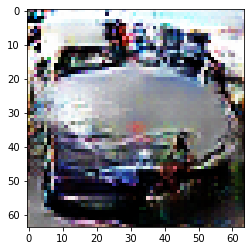

In [8]:
z_test = torch.Tensor(np.random.normal(0, 1, (1, noise_size, 1, 1))).cuda()

n = 0

for epoch in range(epochs):
    loss_g = 0
    loss_d = 0
    n = 0
    for i, data in enumerate(trainloader, 0):
        n+=1
        image, label = data
        for k in range(K):
            optimizer_D.zero_grad()

            image = image.cuda()

            real_label = torch.ones((image.size(0))).cuda()
            fake_label = torch.zeros((image.size(0))).cuda()
            
            real_image_descriminated_label = descriminator(image.detach()).reshape(-1)
            real_loss = loss_1(real_image_descriminated_label, real_label)
            D_x = real_image_descriminated_label.mean().item()

            z = torch.Tensor(np.random.normal(0, 1, (image.size(0), noise_size, 1, 1))).cuda()
            fake_imgs = generator(z).cuda()
            
            fake_image_descriminated_label = descriminator(fake_imgs).reshape(-1)
            fake_loss = loss_1(fake_image_descriminated_label, fake_label)

            d_loss = (real_loss + fake_loss)
            d_loss.backward()
            optimizer_D.step()

            loss_d += d_loss.item()/K


        optimizer_G.zero_grad()

        z = torch.Tensor(np.random.normal(0, 1, (image.size(0), noise_size, 1, 1))).cuda()
        fake_imgs = generator(z).cuda()
        
        fake_image_descriminated_label = descriminator(fake_imgs).cuda().reshape(-1) 
        
        real_label = torch.ones((image.size(0))).cuda()
        generator_loss = loss_1(fake_image_descriminated_label, real_label)
        loss_g += generator_loss.item()

        generator_loss.backward()
        optimizer_G.step()
        
        torch.cuda.synchronize()


    if epoch % 1 == 0:    
        print(f"[Epoch: {epoch}][Batch {i}/{len(trainloader)}] Generator Loss: {loss_g/n}; Discriminator Loss: {loss_d/n}; Dx {D_x}")
        fake_imgs = generator(z_test)
        fake_imgs = fake_imgs.cpu().detach().numpy()[0].transpose((1, 2, 0))
        fake_imgs = 0.5 * fake_imgs + 0.5
        fake_imgs = np.clip(fake_imgs, 0, 1)
        plt.imshow(fake_imgs)
        plt.savefig(f"frames2/epoch_{epoch}_{i}.jpg")
    

## 5. Verificação do Resultado do Gerador

Após a rotina de treinamento, vamos gerar 10 espaços latentes aleatorios, gerar as imagens que eles representam e salvar para verificação posterior.

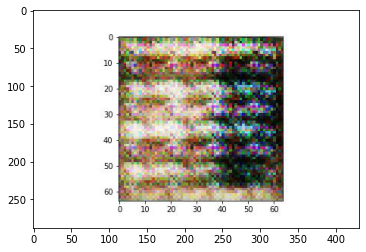

In [1]:
img = mpimg.imread('frames/epoch_0_508.jpg')
imgplot = plt.imshow(img)
plt.show()

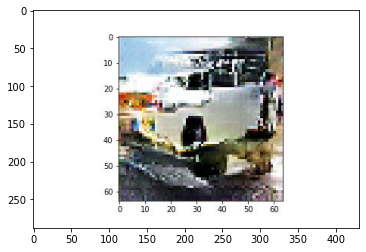

In [3]:
img = mpimg.imread('frames/epoch_300_508.jpg')
imgplot = plt.imshow(img)
plt.show()